#Import necessary library and other files

In [1]:
# Basic imports for data handling
import numpy as np
import pandas as pd
import os
import time
import gc
import random
# Imports for progress bar
from tqdm import tqdm_notebook as tqdm
# Keras imports for the model
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import LearningRateScheduler
# PyTorch imports for neural network functionality
#import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
# Gensim for loading word vectors
from gensim.models import KeyedVectors
# Google Colab import for drive mounting
from google.colab import drive
import matplotlib.pyplot as plt


In [2]:
from tqdm import tqdm
tqdm.pandas()


In [3]:
#Mount to the dir of dataset
drive = drive.mount('/content/drive')
data_dir = 'drive/MyDrive/kaggle_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# to gpu
import torch
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)
device = torch.device('cuda')

CUDA available: True


In [5]:
NUM_MODELS = 2
BATCH_SIZE = 256
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 4
MAX_LEN = 220


In [6]:
import zipfile

#crawl-300d-2M.vec is trained from Common Crawl (a website that collects almost everything)
#it has 2 million words. Each word is represent by a vector of 300 dimensions.
#GloVe is similar to crawl-300d-2M.vec.

zip_file_paths = [
    '/content/drive/MyDrive/kaggle_data/crawl-300d-2M.vec.zip',
    '/content/drive/MyDrive/kaggle_data/glove.840B.300d.txt.zip'
]

for zip_file_path in zip_file_paths:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('/content/drive/MyDrive/kaggle_data/')


In [7]:
#pretrained embedding

EMBEDDING_FILES = [
    '/content/drive/MyDrive/kaggle_data/crawl-300d-2M.vec',
    '/content/drive/MyDrive/kaggle_data/glove.840B.300d.txt'
]

CRAWL_EMBEDDING_PATH = '/content/drive/MyDrive/kaggle_data/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = '/content/drive/MyDrive/kaggle_data/glove.840B.300d.txt'

In [8]:
# load CSV files
train_x = pd.read_csv(os.path.join(data_dir, 'train_x.csv'))
train_y = pd.read_csv(os.path.join(data_dir, 'train_y.csv'))
val_x = pd.read_csv(os.path.join(data_dir, 'val_x.csv'))
val_y = pd.read_csv(os.path.join(data_dir, 'val_y.csv'))
test_x = pd.read_csv(os.path.join(data_dir, 'test_x.csv'))

#EDA

In [10]:
train_x.shape, train_y.shape,val_x.shape, val_y.shape

((269038, 2), (269038, 17), (45180, 2), (45180, 17))

In [11]:
train_x.head()

,index,string
0,0,even up here.......BLACKS!
1,1,Blame men. There's always an excuse to blame ...
2,2,You have no business making any comments on th...
3,3,"""Let's get the black folks and the white folks..."
4,4,I guess the issue is people not willing to put...


In [12]:
train_y.head()

,male,female,LGBTQ,christian,muslim,other_religions,black,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,y,from_source_domain
0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1
1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


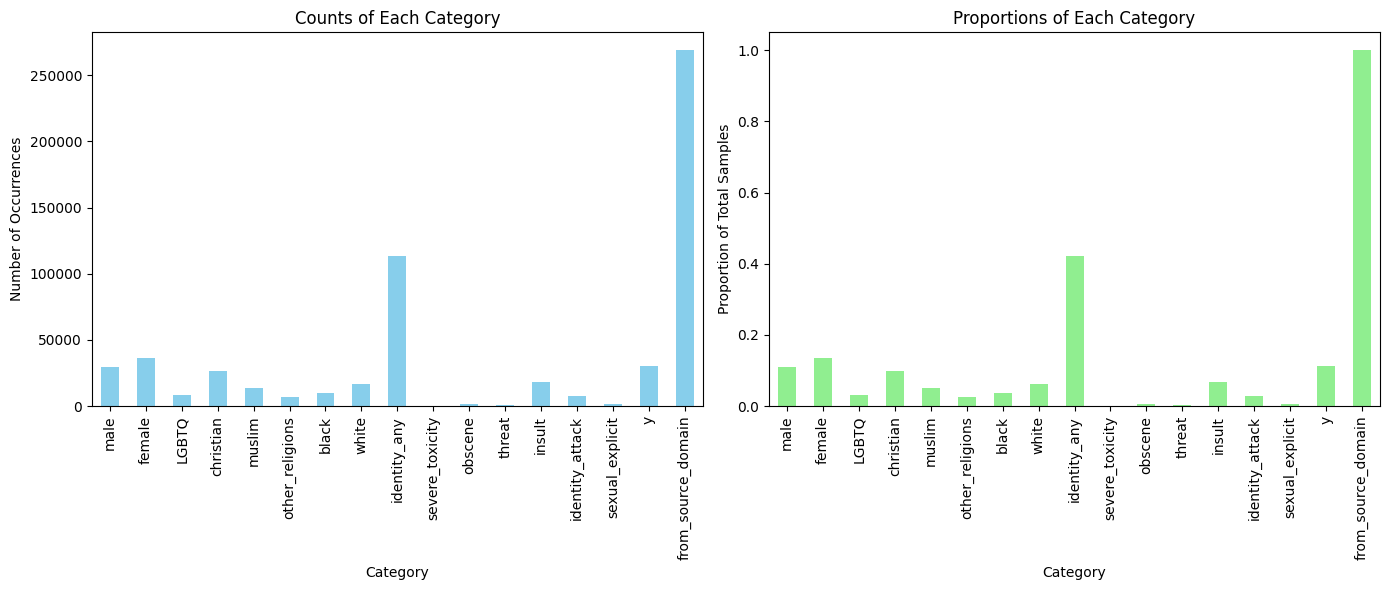

In [13]:
# Visaulize features of train_y's distribution

label_sums = train_y.sum()
total_samples = len(train_y)
label_proportions = label_sums / total_samples

label_distribution = pd.DataFrame({
    'Counts': label_sums,
    'Proportions': label_proportions
})

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

label_distribution['Counts'].plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Counts of Each Category')
ax[0].set_ylabel('Number of Occurrences')
ax[0].set_xlabel('Category')

label_distribution['Proportions'].plot(kind='bar', ax=ax[1], color='lightgreen')
ax[1].set_title('Proportions of Each Category')
ax[1].set_ylabel('Proportion of Total Samples')
ax[1].set_xlabel('Category')

plt.tight_layout()
plt.show()


<Axes: title={'center': 'Correlation of demographic_identities & targets'}>

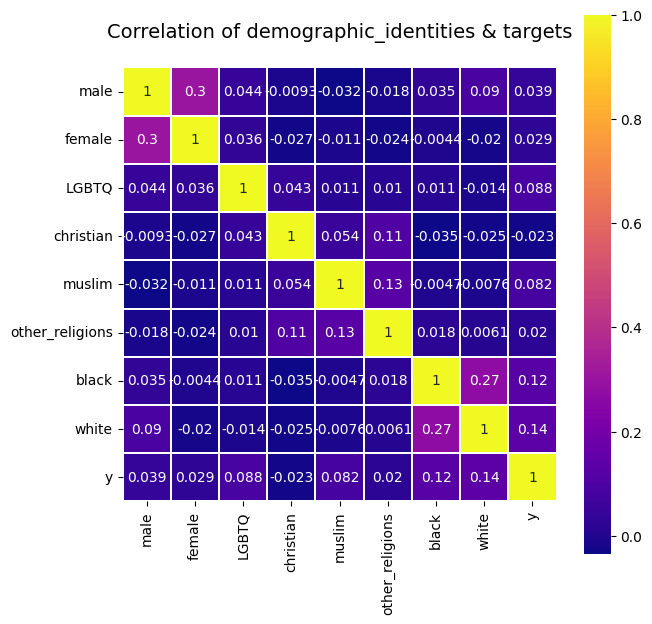

In [14]:
demographic_identities= ['male',	'female',	'LGBTQ',	'christian',	'muslim',	'other_religions',	'black',	'white','y']
data = train_y[demographic_identities]
import seaborn as sns
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of demographic_identities & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

#We observe the correlation accordingly

<Axes: title={'center': 'Correlation of cols_toxity & targets'}>

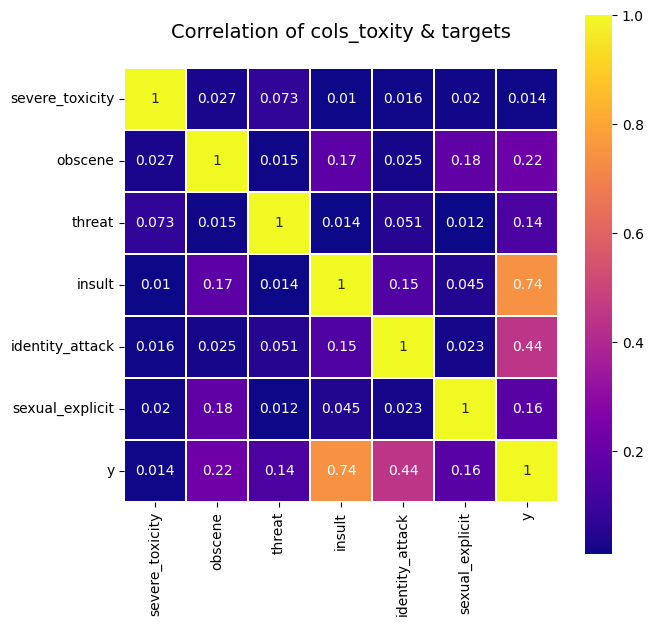

In [15]:
cols_toxity = ['severe_toxicity',	'obscene',	'threat',	'insult',	'identity_attack',	'sexual_explicit','y']
data_2 = train_y[cols_toxity]

colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of cols_toxity & targets',y=1.05,size=14)
sns.heatmap(data_2.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

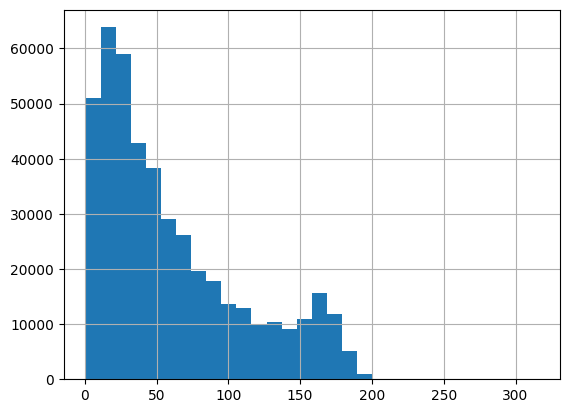

In [16]:
# Get length of all messages in all three sets
train_seq_len = [len(message.split()) for message in train_x['string']]
test_seq_len = [len(message.split()) for message in test_x['string']]
val_seq_len = [len(message.split()) for message in val_x['string']]

all_seq_len = train_seq_len + test_seq_len + val_seq_len
pd.Series(all_seq_len).hist(bins=30)
plt.show()
#Based on the ouput,we set the max_length 200 later

#Preprocessing


In [9]:
#functions to build our embedding matrix

# Function that takes a word and its corresponding embedding vector and returns a tuple containing the word and its embedding vector as a NumPy array.
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

# Function that opens a pre-trained embedding vector file and uses the get_coefs function to create a dictionary
def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)

#Function to build the matrix
def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [10]:
#helper functions
import operator

#find word vectors in matrix
def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

#builds a ordered dictionary of words and their frequency in the text corpus.
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [19]:
tic = time.time()
glove_embeddings = load_embeddings(GLOVE_EMBEDDING_PATH)
print(f'loaded {len(glove_embeddings)} word vectors in {time.time()-tic}s')

loaded 2196008 word vectors in 174.88819766044617s


In [20]:
vocab = build_vocab(list(train_x['string'].apply(lambda x:x.split())))
oov = check_coverage(vocab,glove_embeddings)
oov[:10]

100%|██████████| 529887/529887 [00:00<00:00, 782609.32it/s]


Found embeddings for 24.72% of vocab
Found embeddings for  89.44% of all text


[("isn't", 6706),
 ("That's", 5973),
 ("won't", 4475),
 ("he's", 4027),
 ("Trump's", 3998),
 ("aren't", 3612),
 ('that,', 3373),
 ("wouldn't", 3276),
 ('Yes,', 3256),
 ("wasn't", 3222)]

We have a lot of oovs in the text due to the presence of tokens with punctuation, special characters, or contractions that are not separated properly (e.g., "isn't", "that's").
We would deal with those problems later

In [21]:
import string
latin_similar = "’'‘ÆÐƎƏƐƔĲŊŒẞÞǷȜæðǝəɛɣĳŋœĸſßþƿȝĄƁÇĐƊĘĦĮƘŁØƠŞȘŢȚŦŲƯY̨Ƴąɓçđɗęħįƙłøơşșţțŧųưy̨ƴÁÀÂÄǍĂĀÃÅǺĄÆǼǢƁĆĊĈČÇĎḌĐƊÐÉÈĖÊËĚĔĒĘẸƎƏƐĠĜǦĞĢƔáàâäǎăāãåǻąæǽǣɓćċĉčçďḍđɗðéèėêëěĕēęẹǝəɛġĝǧğģɣĤḤĦIÍÌİÎÏǏĬĪĨĮỊĲĴĶƘĹĻŁĽĿʼNŃN̈ŇÑŅŊÓÒÔÖǑŎŌÕŐỌØǾƠŒĥḥħıíìiîïǐĭīĩįịĳĵķƙĸĺļłľŀŉńn̈ňñņŋóòôöǒŏōõőọøǿơœŔŘŖŚŜŠŞȘṢẞŤŢṬŦÞÚÙÛÜǓŬŪŨŰŮŲỤƯẂẀŴẄǷÝỲŶŸȲỸƳŹŻŽẒŕřŗſśŝšşșṣßťţṭŧþúùûüǔŭūũűůųụưẃẁŵẅƿýỳŷÿȳỹƴźżžẓ"
white_list = string.ascii_letters + string.digits + latin_similar + ' '
white_list += "'"

glove_chars = ''.join([c for c in tqdm(glove_embeddings) if len(c) == 1])
glove_symbols = ''.join([c for c in glove_chars if not c in white_list])

#printed are symbols that we have an embedding vector for
glove_symbols

100%|██████████| 2196008/2196008 [00:00<00:00, 3613821.97it/s]


',.":)(-!?|;$&/[]>%=#*+\\•~@£·_{}©^®`<→°€™›♥←×§″′█½…“★”–●►−¢²¬░¡¶↑±¿▾═¦║―¥▓—‹─▒：¼⊕▼▪†■▀¨▄♫☆¯♦¤▲¸¾⋅∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤¹≤‡√◄━⇒▶º≥╝♡◊。✈≡☺✔↵≈✓♣☎℃◦└‟～！○◆№♠▌✿▸⁄□❖✦．÷｜┃／￥╠↩✭▐☼µ☻┐├«∼┌℉☮฿≦♬✧〉－⌂✖･◕※‖◀‰\x97↺∆┘┬╬،⌘⊂ª＞〈⎙Å？☠⇐▫∗∈≠♀ƒ♔˚℗┗＊┼❀＆∩♂‿∑‣➜┛⇓☯⊖☀┳；∇⇑✰◇♯☞´↔┏｡◘∂✌♭┣┴┓✨ˈ˜❥┫℠✒［∫\x93≧］\x94∀♛\x96∨◎ˑ↻⅓⇩＜≫✩ˆ✪♕؟₤☛╮␊＋┈ɡ％╋▽⇨┻⊗￡।▂✯▇＿➤₂✞＝▷△◙▅✝ﾟ∧␉☭┊╯☾➔∴\x92▃↳＾׳➢╭➡＠⊙☢˝⅛∏„①๑∥❝☐▆╱⋙๏☁⇔▔\x91②➚◡╰٠♢˙۞✘✮☑⋆ℓⓘ❒☣✉⌊➠∣❑⅔◢ⓒ\x80〒∕▮⦿✫✚⋯♩☂ˌ❞‗܂☜‾✜╲∘⟩＼⟨·⅜✗♚∅ⓔ◣͡‛❦⑨③◠✄❄１∃␣≪｢≅◯☽２∎｣⁰❧̅ǡⒶ↘⚓▣˘∪⇢✍⊥＃⅝⎯↠۩☰◥⊆✽ﬁ⚡↪ở❁☹◼☃◤❏ⓢ⊱α➝̣✡∠｀▴┤Ȃ∝♏ⓐ✎;３④␤＇❣⅞✂✤ⓞ☪✴⌒˛♒＄ɪ✶▻Ⓔ◌◈۲Ʈ❚ʿ❂￦◉╜̃ν✱╖❉₃ⓡℝ٤↗❶ʡ۰ˇⓣ♻➽۶₁ʃ׀✲ʤ✬☉▉≒☥⌐♨✕ⓝ⊰❘＂⇧̵➪４▁β۱▏⊃ⓛ‚♰́✏⏑̶٩Ⓢー⩾日￠❍≃⋰♋ɿ､̂❋✳ⓤ╤▕⌣✸℮⁺▨⑤╨Ⓥ♈❃☝５✻⊇≻♘♞◂７✟⌠✠☚✥❊ƂⒸ⌈❅Ⓡ♧Ⓞɑλ۵▭❱Ⓣ∟☕♺∵⍝ⓑɔ✵✣ℤ年ℕ٭♆Ⓘⅆ∶⚜◞்✹Ǥȡ➥ᴥ↕ɂ̳∷✋➧∋̿ͧʘ┅⥤⬆ǀμ₄⋱ʔ☄↖⋮۔♌Ⓛ╕♓ـ⁴❯♍▋✺⭐６✾♊➣▿Ⓑ♉Ａ⏠◾▹⑥⩽в↦╥⍵⌋։➨и∮⇥ⓗⒹ⁻ʊ⎝⌥⌉◔◑ǂ✼♎ℂ♐╪ɨ⊚☒⇤θВⓜ⎠Ｏ◐ǰ⚠╞ﬂ◗⎕ⓨ☟Ｉⓟ♟❈↬ⓓ◻♮❙а♤∉؛⁂例Ⓝ־♑╫╓╳⬅☔πɒɹ߂☸ɐʻ┄╧ʌ׃８ʒ⎢❆⋄⚫̏☏➞͂␙Ⓤ◟Ƥʕ̊Ȥ⚐✙は↙̾ωΔ℘ﾞ✷⑦φ⍺❌⊢▵✅ｗ９ⓖ☨▰ʹ╡Ⓜ☤∽╘˹↨ȿ♙⬇♱⌡Ω⠀╛❕┉Ⓟ̀Ǩ♖ⓚ┆⑧⎜ǹ◜⚾⤴✇╟⎛☩➲➟ⓥⒽ⏝◃０₀╢月↯✆˃⍴❇⚽╒Ｃɻɤ̸♜☓Ｔ➳⇄γ☬⚑✐⁵δȭ⌃◅▢ｓȸ❐∊☈ⅇℜ॥σ⎮ȣ▩のτεＳு⊹‵␔☊➸̌☿⇉➊⊳╙⁶ⓦ⇣｛̄↝⎟ℳ▍❗ℑＭɾｍ״Γ΄▞◁⛄⇝⎪ˤ♁ｖ⇠☇✊位ℒạி｝๐⭕➘Ｂ❺ɸˡ⁀⑩ｃ⅕Ƽ۳☙❛₆ƪ❓⟲Ʒ⇀≲Ｐ❷١ⓕ⎥Ｄс\u06ddǥͤ₋̱̎♝≳▙Ｒʹ➭ℰ܀ʺȫⒼ⇛ˉ▊❸号⇗̷

In [22]:
chars = build_vocab(list(train_x['string']))
symbols_to_isolate = ''.join([c for c in chars if not c in white_list])
symbols_to_isolate

100%|██████████| 269038/269038 [00:12<00:00, 22150.40it/s]


'.!,":\n-?();$/&*_“”^%…#[]>`@=™<}+|‑\\\u200b~😂😋\x7f–😆😛🤡😃\xa0ˈ😇巨大的税收！赢得年月。你失去了所有钱白鬼愤怒来不要买卖额😝—¥الإسم\xad😞🤑😡▀―овца«»☠️💀🆘🔥💥💨🐴{👎\u2006\u2004▰▱ℐ✨🏐🏉\t👍🏼😀☹😬😳ʻ̶г⚾⚽💖½×😊😣😉😒🙃¢😖😜🇨🇦😈😅🙄•♫💪🙏🎯😄😁👶🤧🤓´£·ˌ🤔𝙏𝙝𝙚𝙗𝙞𝙜𝙥𝙧𝙤𝙡𝙢𝙨𝙖𝙮𝙣𝙩𝙛𝙪𝙘𝙫𝙔𝙬𝙠𝙙😎§☺¯ツᴛᴀʀᴡᴏᴋɪɴɢғᴍʜᴇᴊʙᴜᴅʏᴄʟᴘᴠ🦊💰°♪♬®➤ᴵ\u200f🤯😤🤤😫🤥🤪🙈🙉🙊🐡❄🔫♀►●😕😑ɡ👏💡≠⁄º₂🎶\u200a💯✔💕💎⇒\ufeff†\u2009²приет😲🤗😔\u200e±❤◄▬ஜ\u202a\u202c©℅🤣🐟☻░▒▓█😢🌟Μ″❆😵😙𝗢𝗻𝗲𝟳𝟱𝟬∞🍺𝑩𝒆𝒉𝒐𝒍𝒅𝑰𝒔𝒕𝒂𝒏𝒓𝒌𝒄𝒇𝒚𝒎𝒗𝒊𝒑𝒘𝒀𝒖𝒒𝒈𝒛𝒃𝑻𝑺˚أهكتب′😦❣„○成都😩👮\u2028🖐マルハニチロ株式会社ксьы✰▄，ɒʃ\u3000𝙄👌💜歌舞伎☑͞¹❌⭕🌞¨﴾͡๏̯﴿😍☐🐻🤢😭🇵🇷🇺🇸💵🎄💟💋🎰🌺\x81♥🤘🙁🙀€😮👼👿▶حريةو￼−🏝μετουσίωις÷⠀καρό😐🙂：‖ἔλψ😴╪\u2005▔🤴д𝒩ℯ𝒾𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎¡🇳✅✋⚡☄👊🏻¿🚽ق😨›♡\x08̣🐽Ам🍁\x10ὐφνύύ┈╱╲▏━╮▕┃╰▊▋╯╭┳▂┊\uf04aΔ₀ːʒ\x96\x92ʌ⤵🤕🤒外国人ɑ⦁\x95Ｉ\u2002چزیγήἀάπη😟\r😠∎Ἰᾶὁέ𝓒𝓲𝓿𝓵◕✾✈¶бюш🦁👠خِفَʿ✘𝒋𝟒𝟔💩⏺\u202d⎌͜ʖ\x13عدصنىغ😱💤🌍ἐ是𝐡𝐭𝐩𝐬𝐰𝐲𝐨𝐮𝐛𝐞𝐜𝐦𝐚𝐯𝐳𝐔𝐱𝟓𝐅𝐓𝐃𝐘🕷🎁𝒙😶关系）小土豆🌏⅓☆¬𝗕𝗰𝗮𝗿𝗳𝘂𝗹𝗼𝘁𝗽𝗶𝘆𝗴𝗵𝘀𝗯𝗺𝗜𝗱𝘄𝘃𝗙𝗦𝗧𝙭ﬁ★❥😏☕שואה⚠\uf04c☭🏆💛💚💙🌸МлнйДТч🎼˙𝘴𝘰𝘮𝘦𝘵𝘩𝘪𝘯𝘨➥．ＣＯＭ✬═🏾◐😥🐒‐\u202f\u2008≤✌😪☝🏽зу🌮ῦﬂ‼❔❓⁉❗¼'

In [23]:
#The symbols we want to keep we need to isolate from our words.
symbols_to_isolate = ''.join([c for c in symbols_to_isolate if c in glove_symbols])
symbols_to_isolate

'.!,":-?();$/&*_“”^%…#[]>`@=™<}+|\\~–ˈ！年月。—¥▀―ва«»☠{▰✨☹ʻ̶⚾⚽½×¢•♫´£·ˌ§☺¯ɪ°♪♬®➤❄♀►●ɡ≠⁄º₂✔⇒†²и±❤◄▬©℅☻░▒▓█″❆∞˚′❣„○с✰▄，ɒʃ☑¹❌⭕¨͡๏☐♥€▶−μετσω÷⠀αρ：‖λ╪▔¡✅✋⚡☄¿›♡̣φν┈╱╲▏━╮▕┃╰▊▋╯╭┳▂┊Δ₀ːʒ\x96\x92ʌɑＩγπη∎◕✾✈¶ʿ✘）⅓☆¬ﬁ★❥☕⚠☭˙➥．ＣＯＭ✬═◐≤✌☝ﬂ❓❗¼'

In [24]:
#Now we have all information we need for preprocessing

In [11]:
symbols_to_isolate = '.,?!-;*"…:—()%#$&_/@＼・ω+=”“[]^–>\\°<~•≠™ˈʊɒ∞§{}·τα❤☺ɡ|¢→̶`❥━┣┫┗Ｏ►★©―ɪ✔®\x96\x92●£♥➤´¹☕≈÷♡◐║▬′ɔː€۩۞†μ✒➥═☆ˌ◄½ʻπδηλσερνʃ✬ＳＵＰＥＲＩＴ☻±♍µº¾✓◾؟．⬅℅»Вав❣⋅¿¬♫ＣＭβ█▓▒░⇒⭐›¡₂₃❧▰▔◞▀▂▃▄▅▆▇↙γ̄″☹➡«φ⅓„✋：¥̲̅́∙‛◇✏▷❓❗¶˚˙）сиʿ✨。ɑ\x80◕！％¯−ﬂﬁ₁²ʌ¼⁴⁄₄⌠♭✘╪▶☭✭♪☔☠♂☃☎✈✌✰❆☙○‣⚓年∎ℒ▪▙☏⅛ｃａｓǀ℮¸ｗ‚∼‖ℳ❄←☼⋆ʒ⊂、⅔¨͡๏⚾⚽Φ×θ￦？（℃⏩☮⚠月✊❌⭕▸■⇌☐☑⚡☄ǫ╭∩╮，例＞ʕɐ̣Δ₀✞┈╱╲▏▕┃╰▊▋╯┳┊≥☒↑☝ɹ✅☛♩☞ＡＪＢ◔◡↓♀⬆̱ℏ\x91⠀ˤ╚↺⇤∏✾◦♬³の｜／∵∴√Ω¤☜▲↳▫‿⬇✧ｏｖｍ－２０８＇‰≤∕ˆ⚜☁'
symbols_to_delete = '\n🍕\r🐵😑\xa0\ue014\t\uf818\uf04a\xad😢🐶️\uf0e0😜😎👊\u200b\u200e😁عدويهصقأناخلىبمغر😍💖💵Е👎😀😂\u202a\u202c🔥😄🏻💥ᴍʏʀᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢ😋👏שלוםבי😱‼\x81エンジ故障\u2009🚌ᴵ͞🌟😊😳😧🙀😐😕\u200f👍😮😃😘אעכח💩💯⛽🚄🏼ஜ😖ᴠ🚲‐😟😈💪🙏🎯🌹😇💔😡\x7f👌ἐὶήιὲκἀίῃἴξ🙄Ｈ😠\ufeff\u2028😉😤⛺🙂\u3000تحكسة👮💙فزط😏🍾🎉😞\u2008🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪\x08‑🐰🐇🐱🙆😨🙃💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚地獄谷улкнПоАН🐾🐕😆ה🔗🚽歌舞伎🙈😴🏿🤗🇺🇸мυтѕ⤵🏆🎃😩\u200a🌠🐟💫💰💎эпрд\x95🖐🙅⛲🍰🤐👆🙌\u2002💛🙁👀🙊🙉\u2004ˢᵒʳʸᴼᴷᴺʷᵗʰᵉᵘ\x13🚬🤓\ue602😵άοόςέὸתמדףנרךצט😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓\uf0b7\uf04c\x9f\x10成都😣⏺😌🤑🌏😯ех😲Ἰᾶὁ💞🚓🔔📚🏀👐\u202d💤🍇\ue613小土豆🏡❔⁉\u202f👠》कर्मा🇹🇼🌸蔡英文🌞🎲レクサス😛外国人关系Сб💋💀🎄💜🤢َِьыгя不是\x9c\x9d🗑\u2005💃📣👿༼つ༽😰ḷЗз▱ц￼🤣卖温哥华议会下降你失去所有的钱加拿大坏税骗子🐝ツ🎅\x85🍺آإشء🎵🌎͟ἔ油别克🤡🤥😬🤧й\u2003🚀🤴ʲшчИОРФДЯМюж😝🖑ὐύύ特殊作戦群щ💨圆明园קℐ🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦\u200d𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪天一家⚲\u2006⚭⚆⬭⬯⏖新✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼𝘂𝗿𝗮𝗹𝗶𝘇𝗯𝘁𝗰𝘀𝘅𝗽𝘄𝗱📺ϖ\u2000үսᴦᎥһͺ\u2007հ\u2001ɩｙｅ൦ｌƽｈ𝐓𝐡𝐞𝐫𝐮𝐝𝐚𝐃𝐜𝐩𝐭𝐢𝐨𝐧Ƅᴨןᑯ໐ΤᏧ௦Іᴑ܁𝐬𝐰𝐲𝐛𝐦𝐯𝐑𝐙𝐣𝐇𝐂𝐘𝟎ԜТᗞ౦〔Ꭻ𝐳𝐔𝐱𝟔𝟓𝐅🐋ﬃ💘💓ё𝘥𝘯𝘶💐🌋🌄🌅𝙬𝙖𝙨𝙤𝙣𝙡𝙮𝙘𝙠𝙚𝙙𝙜𝙧𝙥𝙩𝙪𝙗𝙞𝙝𝙛👺🐷ℋ𝐀𝐥𝐪🚶𝙢Ἱ🤘ͦ💸ج패티Ｗ𝙇ᵻ👂👃ɜ🎫\uf0a7БУі🚢🚂ગુજરાતીῆ🏃𝓬𝓻𝓴𝓮𝓽𝓼☘﴾̯﴿₽\ue807𝑻𝒆𝒍𝒕𝒉𝒓𝒖𝒂𝒏𝒅𝒔𝒎𝒗𝒊👽😙\u200cЛ‒🎾👹⎌🏒⛸公寓养宠物吗🏄🐀🚑🤷操美𝒑𝒚𝒐𝑴🤙🐒欢迎来到阿拉斯ספ𝙫🐈𝒌𝙊𝙭𝙆𝙋𝙍𝘼𝙅ﷻ🦄巨收赢得白鬼愤怒要买额ẽ🚗🐳𝟏𝐟𝟖𝟑𝟕𝒄𝟗𝐠𝙄𝙃👇锟斤拷𝗢𝟳𝟱𝟬⦁マルハニチロ株式社⛷한국어ㄸㅓ니͜ʖ𝘿𝙔₵𝒩ℯ𝒾𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎𝙏ζ𝙟𝘃𝗺𝟮𝟭𝟯𝟲👋🦊多伦🐽🎻🎹⛓🏹🍷🦆为和中友谊祝贺与其想象对法如直接问用自己猜本传教士没积唯认识基督徒曾经让相信耶稣复活死怪他但当们聊些政治题时候战胜因圣把全堂结婚孩恐惧且栗谓这样还♾🎸🤕🤒⛑🎁批判检讨🏝🦁🙋😶쥐스탱트뤼도석유가격인상이경제황을렵게만들지않록잘관리해야합다캐나에서대마초와화약금의품런성분갈때는반드시허된사용🔫👁凸ὰ💲🗯𝙈Ἄ𝒇𝒈𝒘𝒃𝑬𝑶𝕾𝖙𝖗𝖆𝖎𝖌𝖍𝖕𝖊𝖔𝖑𝖉𝖓𝖐𝖜𝖞𝖚𝖇𝕿𝖘𝖄𝖛𝖒𝖋𝖂𝕴𝖟𝖈𝕸👑🚿💡知彼百\uf005𝙀𝒛𝑲𝑳𝑾𝒋𝟒😦𝙒𝘾𝘽🏐𝘩𝘨ὼṑ𝑱𝑹𝑫𝑵𝑪🇰🇵👾ᓇᒧᔭᐃᐧᐦᑳᐨᓃᓂᑲᐸᑭᑎᓀᐣ🐄🎈🔨🐎🤞🐸💟🎰🌝🛳点击查版🍭𝑥𝑦𝑧ＮＧ👣\uf020っ🏉ф💭🎥Ξ🐴👨🤳🦍\x0b🍩𝑯𝒒😗𝟐🏂👳🍗🕉🐲چی𝑮𝗕𝗴🍒ꜥⲣⲏ🐑⏰鉄リ事件ї💊「」\uf203\uf09a\uf222\ue608\uf202\uf099\uf469\ue607\uf410\ue600燻製シ虚偽屁理屈Г𝑩𝑰𝒀𝑺🌤𝗳𝗜𝗙𝗦𝗧🍊ὺἈἡχῖΛ⤏🇳𝒙ψՁմեռայինրւդձ冬至ὀ𝒁🔹🤚🍎𝑷🐂💅𝘬𝘱𝘸𝘷𝘐𝘭𝘓𝘖𝘹𝘲𝘫کΒώ💢ΜΟΝΑΕ🇱♲𝝈↴💒⊘Ȼ🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻𝐎𝐍𝐊𝑭🤖🎎😼🕷ｇｒｎｔｉｄｕｆｂｋ𝟰🇴🇭🇻🇲𝗞𝗭𝗘𝗤👼📉🍟🍦🌈🔭《🐊🐍\uf10aლڡ🐦\U0001f92f\U0001f92a🐡💳ἱ🙇𝗸𝗟𝗠𝗷🥜さようなら🔼'
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
contraction_mapping = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've":
    "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not",
    "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's":"this is","that'd": "that would",
    "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is",
    "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
    "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
    "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is",
    "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
    "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
    "trump's": "trump is", "obama's": "obama is", "canada's": "canada is", "today's": "today is"}
specials = ["’", "‘", "´", "`"]
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
remove_dict = {ord(c):f'' for c in symbols_to_delete}


def handle_punctuation(x):
    x = x.translate(remove_dict)
    x = x.translate(isolate_dict)
    return x

def handle_contractions(x):
    x = tokenizer.tokenize(x)
    return x

def fix_quote(x):
    x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
    x = ' '.join(x)
    return x

def preprocess(x):
    x = handle_punctuation(x)
    x = handle_contractions(x)
    x = fix_quote(x)
    return x

In [12]:
train_x['string'] = train_x['string'].progress_apply(lambda x:preprocess(x))
val_x['string'] = val_x['string'].progress_apply(lambda x:preprocess(x))

test_x['string'] = test_x['string'].progress_apply(lambda x:preprocess(x))

100%|██████████| 133782/133782 [00:39<00:00, 3370.01it/s]


In [27]:
train_x.head(), train_x.shape

(   index                                             string
 0      0                even up here . . . . . . . BLACKS !
 1      1  Blame men . There s always an excuse to blame ...
 2      2  You have no business making any comments on th...
 3      3  `` Let s get the black folks and the white fol...
 4      4  I guess the issue is people not willing to put...,
 (269038, 2))

In [28]:
vocab = build_vocab(list(train_x['string'].apply(lambda x:x.split())),verbose=False)
oov = check_coverage(vocab,glove_embeddings)
oov[:10]

100%|██████████| 180153/180153 [00:00<00:00, 456002.10it/s]


Found embeddings for 73.74% of vocab
Found embeddings for  99.61% of all text


[('don’t', 1037),
 ('it’s', 607),
 ('It’s', 554),
 ('Trump’s', 526),
 ('I’m', 469),
 ('tRump', 437),
 ('doesn’t', 370),
 ('can’t', 325),
 ('didn’t', 309),
 ("gov't", 291)]

In [29]:
#By doing these preprocessing，we increase our Found embeddings from  24.72% of vocab to 73.74  for vocab
#and Found embeddings from 89.44% to 99.61% for all text
#as well as deliminating some high frequency oovs

#Prepare the model

In [13]:
NUM_MODELS = 2
BATCH_SIZE = 512
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 4
MAX_LEN = 200
MAX_FEATURES = 120000

IDENTITY_COLUMNS = ['male',	'female',	'LGBTQ',	'christian',	'muslim',	'other_religions',	'black',	'white']
AUX_COLUMNS = ['severe_toxicity',	'obscene',	'threat',	'insult',	'identity_attack',	'sexual_explicit','y']
TEXT_COLUMN = 'string'
TARGET_COLUMN = 'y'

In [14]:
def seed_everything(seed=10086):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [15]:
# Overall
weights = np.ones((len(train_x),)) / 4
# Subgroup
weights += (train_y[IDENTITY_COLUMNS].fillna(0).values).sum(axis=1) / 4
# Background Positive, Subgroup Negative
weights += (((train_y['y'].values) + (train_y[IDENTITY_COLUMNS].fillna(0).values < 0.5).sum(axis=1)) > 1) / 4
# Background Negative, Subgroup Positive
weights += (((train_y['y'].values < 0.5) + (train_y[IDENTITY_COLUMNS].fillna(0).values >= 0.5).sum(axis=1)) > 1) / 4
loss_weight = 1.0 / weights.mean()


In [16]:
#preprocessing the data for later usage
x_train = train_x[TEXT_COLUMN].astype(str)
x_val = val_x[TEXT_COLUMN].astype(str)
x_test = test_x[TEXT_COLUMN].astype(str)


In [17]:
#converge the training and validation sets to increase model accuracy when predicting
train_x_augmented = pd.concat([train_x, val_x], ignore_index=True)
x_train_augmented = train_x_augmented[TEXT_COLUMN].astype(str)

In [18]:
#tokenizing the corpus, limiting the tokenizer to 120000 words
#for column in IDENTITY_COLUMNS + [TARGET_COLUMN]:
tokenizer = text.Tokenizer(num_words=MAX_FEATURES, filters='',lower=False)
tokenizer.fit_on_texts(list(x_train) + list(x_val) + list(x_test))


In [19]:
#Sequence Bucketing
x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)
x_train_augmented = tokenizer.texts_to_sequences(x_train_augmented)

In [20]:
#making sure that every sentence is of equal length by adding padding
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_val = sequence.pad_sequences(x_val, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)
x_train_augmented = sequence.pad_sequences(x_train_augmented, maxlen=MAX_LEN)

In [21]:
#building the embedding matrix
embedding_matrix = np.concatenate(
    [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES], axis=-1)

In [22]:
from keras.losses import binary_crossentropy
def custom_loss(y_true, y_pred):
    return binary_crossentropy(K.reshape(y_true[:,0],(-1,1)), y_pred) * y_true[:,1]

In [23]:
def build_model(embedding_matrix, num_aux_targets, loss_weight):
    words = Input(shape=(MAX_LEN,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)

    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss=[custom_loss,'binary_crossentropy'], loss_weights=[loss_weight, 1.0], optimizer='adam',metrics=['accuracy'])

    return model


#Train the model

In [24]:
# Metrics measuring accuracies in different groups
def group_accuracies(prediction, y):
    """
    Compute the percentage of correctly classified instances within each group and round them to four decimal places.
    arguments:
        prediction [pandas.DataFrame]: dataframe with 2 columns (index and pred)
        y [pandas.DataFrame]: dataframe containing the metadata with actual labels
    returns:
        accuracies_dict [dict]: dictionary with group names as keys and their percentage of correctly classified instances as values
    """
    y.loc[prediction.index, 'pred'] = prediction.pred

    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies_dict = {}
    for category in categories:
        group = y.loc[y[category] == 1]
        if not group.empty:
            group_accuracy = (group['y'] == group['pred']).mean()
            accuracies_dict[category] = round(group_accuracy * 100, 4)
    return accuracies_dict


In [25]:
train_y = train_y.drop('from_source_domain', axis=1)
val_y = val_y.drop('from_source_domain', axis=1)

y_train = train_y[TARGET_COLUMN].values
y_aux_train = train_y[AUX_COLUMNS].values


In [26]:
y_train = np.vstack([(train_y[TARGET_COLUMN].values>=0.5).astype(np.int),weights]).T
y_aux_train = train_y[AUX_COLUMNS].values

<ipython-input-26-9c3a8462276d>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.vstack([(train_y[TARGET_COLUMN].values>=0.5).astype(np.int),weights]).T


In [27]:
x_train.shape,y_train.shape, y_aux_train.shape

((269038, 200), (269038, 2), (269038, 7))

In [28]:
checkpoint_val = []

In [29]:
#fitting model on whole training data
from keras import backend as K

for model_idx in range(NUM_MODELS):
    print('Model ', model_idx)
    model = build_model(embedding_matrix, y_aux_train.shape[-1], loss_weight)
    for global_epoch in range(1):
        model.fit(
            x_train,
            [y_train, y_aux_train],
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=1,
            callbacks=[
                LearningRateScheduler(lambda _: 1e-3 * (0.55 ** global_epoch))

            ]
        )
        checkpoint_val.append(model.predict(x_val, batch_size=2048)[0].flatten())



Model  0
23/23 [==============================] - 9s 348ms/step
Model  1
23/23 [==============================] - 9s 351ms/step


In [30]:
val_predictions = np.average(checkpoint_val, axis=0)
pred = [1 if pred > 0.50 else 0 for pred in val_predictions]

prediction_df = pd.DataFrame.from_dict({
    'ID': val_y.index,
    'pred': pred
})

group_accs = group_accuracies(prediction_df, val_y)
print(group_accs)

{'male': 89.255, 'female': 90.3751, 'LGBTQ': 80.3706, 'christian': 92.8791, 'muslim': 80.6635, 'other_religions': 87.2211, 'black': 75.3632, 'white': 78.7583}


<ipython-input-24-c0a3fcb5de0b>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  y.loc[prediction.index, 'pred'] = prediction.pred


In [ ]:
#We are now ok with the output

In [ ]:
# Overall
weights = np.ones((len(x_train_augmented),)) / 4
# Subgroup
weights += (train_y_augmented[IDENTITY_COLUMNS].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4
# Background Positive, Subgroup Negative
weights += (( (train_y_augmented['y'].values>=0.5).astype(bool).astype(np.int) +
   (train_y_augmented[IDENTITY_COLUMNS].fillna(0).values<0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
# Background Negative, Subgroup Positive
weights += (( (train_y_augmented['y'].values<0.5).astype(bool).astype(np.int) +
   (train_y_augmented[IDENTITY_COLUMNS].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
loss_weight = 1.0 / weights.mean()

In [34]:
train_y_augmented = pd.concat([train_y, val_y], axis=0, ignore_index=True)


y_aux_train = train_y_augmented[AUX_COLUMNS].values
y_train = np.vstack([(train_y_augmented['y'].values>=0.5).astype(np.int),weights]).T

<ipython-input-34-bd1f515eb4e1>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.vstack([(train_y_augmented['y'].values>=0.5).astype(np.int),weights]).T


In [35]:
checkpoint_predictions = []

In [36]:
#fitting model on whole training data
from keras import backend as K

for model_idx in range(NUM_MODELS):
    print('Model ', model_idx)
    model = build_model(embedding_matrix, y_aux_train.shape[-1], loss_weight)
    for global_epoch in range(EPOCHS):
        model.fit(
            x_train_augmented,
            [y_train, y_aux_train],
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=1,
            callbacks=[
                LearningRateScheduler(lambda _: 1e-3 * (0.55 ** global_epoch))

            ]
        )
        checkpoint_predictions.append(model.predict(x_test, batch_size=2048)[0].flatten())


Model  0
66/66 [==============================] - 24s 363ms/step
Model  1
66/66 [==============================] - 24s 363ms/step


In [37]:
predictions = np.average(checkpoint_predictions, axis=0)
pred = [1 if pred > 0.5 else 0 for pred in predictions]

submission = pd.DataFrame.from_dict({
    'ID': test_x.index,
    'pred': pred
})
submission.to_csv('submission.csv', index=False)

In [38]:
pred_counts = submission['pred'].value_counts()

print(pred_counts)

0    121778
1     12004
Name: pred, dtype: int64
